In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 34.0 MB/s 
     |████████████████████████████████| 209 kB 43.6 MB/s 
     |████████████████████████████████| 81 kB 7.5 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 112 kB 47.3 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 146 kB 51.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=e5b2e42cbe5689d600e3194bc0b79ae80b83df8187435724c4b13e1ad6e8dfed
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_v1.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']
training_data = scaler.fit_transform(data[scale_cols])


In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []
    
    for i in range(len(data) - seq_length - 1):
        _x = data[i: (i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(data, seq_length, train_batch_size, test_batch_size):

    x, y = sliding_windows(data, seq_length)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = train_batch_size)

    test_ds = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
    test_dl = DataLoader(test_ds, batch_size = test_batch_size)

    input_size = x_train.shape[-1]

    return train_dl, test_dl, input_size, x_train, x_test, y_train, y_test

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
def train(log_interval, model, train_dl, optimizer, criterion, epoch):
    model.train()
    for epoch in range(epoch):
        best_loss = np.inf
        for data, target in train_dl:
            output = model(data)
            optimizer.zero_grad()
            loss = criterion(output, target) # mean-squared error for regression
            loss.backward()
            optimizer.step()
            best_loss = min(loss, best_loss)

        if ( epoch % log_interval == 0 ):
            print(f'Epoch: {epoch}, loss: {loss.item()}')

    return best_loss


def test_predict(model, test_dl):
    model.eval()
    pred = []
    with torch.no_grad():
        for data, target in test_dl:
            train_predict = model(data)
            pred.extend(train_predict.data.numpy().squeeze()) 

    return pred


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [7]:
def objective(trial):

    cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
            'train_batch_size' : trial.suggest_categorical('train_batch_size',[64, 128, 256]), # [64, 128, 256]
            'test_batch_size' : trial.suggest_categorical('test_batch_size',[64, 128, 256]),  # [64, 128, 256]
            'num_epochs' : trial.suggest_int('num_epochs', 1000, 1600, 100), 
            'save_model' : False,
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            'momentum': trial.suggest_uniform('momentum', 0.4, 0.99),
            'optimizer': trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]), # trial.suggest_categorical('optimizer',[optim.SGD, optim.Adam]),
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size',[64, 128, 256]),
            'num_layers': trial.suggest_int('num_layers', 1, 1),
            'num_classes': trial.suggest_int('num_classes', 1, 1),
            'seed': 42,
            'log_interval' : 100 }

    torch.manual_seed(cfg['seed'])

    train_dl, test_dl, input_size, x_train, x_test, y_train, y_test = get_data_loader(training_data, 20, cfg['train_batch_size'], cfg['test_batch_size'])
    model = LSTM(num_classes=cfg['num_classes'], input_size=input_size, hidden_size=cfg['hidden_size'], num_layers=cfg['num_layers'])
    optimizer = cfg['optimizer'](model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()

    train(cfg['log_interval'], model, train_dl, optimizer, criterion, cfg['num_epochs'])

    if cfg['save_model']:
        torch.save(model.state_dict(), "lstm.pt")

    pred = test_predict(model, test_dl)

    predict = scaler.inverse_transform(np.expand_dims(pred, axis = 1))
    actual = scaler.inverse_transform(y_test)

    SMAPE = smape(actual, predict)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [8]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=5) 
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna.pkl')
joblib.dump(study, '/content/lstm_optuna.pkl')

[I 2022-06-05 05:27:54,013] A new study created in memory with name: no-name-99c4244f-7790-4c62-8be5-b9127c93564c


Epoch: 0, loss: 8.453742027282715
Epoch: 100, loss: 0.007955116219818592
Epoch: 200, loss: 0.010953389108181
Epoch: 300, loss: 0.08694202452898026
Epoch: 400, loss: 0.477968692779541
Epoch: 500, loss: 0.032075636088848114
Epoch: 600, loss: 0.011894891038537025
Epoch: 700, loss: 0.024685438722372055
Epoch: 800, loss: 0.021661674603819847
Epoch: 900, loss: 0.025611260905861855
Epoch: 1000, loss: 0.030737707391381264
Epoch: 1100, loss: 0.020291756838560104
Epoch: 1200, loss: 0.020725460723042488
Epoch: 1300, loss: 0.0198191087692976


[I 2022-06-05 05:51:46,817] Trial 0 finished with value: 16.762334860728064 and parameters: {'train_batch_size': 256, 'test_batch_size': 64, 'num_epochs': 1400, 'learning_rate': 0.06133142312841739, 'momentum': 0.6579241328282422, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 0 with value: 16.762334860728064.


 
SMAPE : 16.762334860728064
Epoch: 0, loss: 0.05044681578874588
Epoch: 100, loss: 0.0019977192860096693
Epoch: 200, loss: 0.0020054138731211424
Epoch: 300, loss: 0.001954310107976198
Epoch: 400, loss: 0.0019076783210039139
Epoch: 500, loss: 0.001864945748820901
Epoch: 600, loss: 0.0018256139010190964
Epoch: 700, loss: 0.0017892802134156227
Epoch: 800, loss: 0.001755590783432126
Epoch: 900, loss: 0.0017242578323930502
Epoch: 1000, loss: 0.0016950198914855719


[I 2022-06-05 06:11:24,741] Trial 1 finished with value: 4.672183984885252 and parameters: {'train_batch_size': 64, 'test_batch_size': 64, 'num_epochs': 1100, 'learning_rate': 0.048305826050096715, 'momentum': 0.4692156749153549, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 1 with value: 4.672183984885252.


 
SMAPE : 4.672183984885252
Epoch: 0, loss: 0.0025470207910984755
Epoch: 100, loss: 0.0026556835509836674
Epoch: 200, loss: 0.0012891142396256328
Epoch: 300, loss: 0.0019552004523575306
Epoch: 400, loss: 0.0011671518441289663
Epoch: 500, loss: 0.0010029175318777561
Epoch: 600, loss: 0.0009930097730830312
Epoch: 700, loss: 0.0015618724282830954
Epoch: 800, loss: 0.0015424106968566775
Epoch: 900, loss: 0.0016445521032437682
Epoch: 1000, loss: 0.0019052199786528945
Epoch: 1100, loss: 0.015628300607204437
Epoch: 1200, loss: 0.011239887215197086
Epoch: 1300, loss: 0.0014695704448968172
Epoch: 1400, loss: 0.13669933378696442


[I 2022-06-05 06:30:12,432] Trial 2 finished with value: 26.790335666721095 and parameters: {'train_batch_size': 64, 'test_batch_size': 64, 'num_epochs': 1500, 'learning_rate': 0.06372068414909914, 'momentum': 0.7380826101427593, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 64, 'num_layers': 1, 'num_classes': 1}. Best is trial 1 with value: 4.672183984885252.


 
SMAPE : 26.790335666721095
Epoch: 0, loss: 0.0007623572018928826
Epoch: 100, loss: 0.0011180239962413907
Epoch: 200, loss: 0.028897708281874657
Epoch: 300, loss: 0.002755456604063511
Epoch: 400, loss: 0.0019931793212890625
Epoch: 500, loss: 0.0009985717479139566
Epoch: 600, loss: 0.001423268811777234
Epoch: 700, loss: 0.0015426635509356856
Epoch: 800, loss: 0.0012407865142449737
Epoch: 900, loss: 0.0014863992109894753
Epoch: 1000, loss: 0.0014059070963412523
Epoch: 1100, loss: 0.0009852416114881635
Epoch: 1200, loss: 0.001089477096684277


[I 2022-06-05 06:54:10,610] Trial 3 finished with value: 5.904411833061534 and parameters: {'train_batch_size': 64, 'test_batch_size': 64, 'num_epochs': 1300, 'learning_rate': 0.018099696574023248, 'momentum': 0.8662399533717513, 'optimizer': <class 'torch.optim.adam.Adam'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 1 with value: 4.672183984885252.


 
SMAPE : 5.904411833061534
Epoch: 0, loss: 0.08632474392652512
Epoch: 100, loss: 0.0012693320168182254
Epoch: 200, loss: 0.0018689639400690794
Epoch: 300, loss: 0.001873935922048986
Epoch: 400, loss: 0.0018523888429626822
Epoch: 500, loss: 0.0018316438654437661
Epoch: 600, loss: 0.0018117816653102636
Epoch: 700, loss: 0.0017927199369296432
Epoch: 800, loss: 0.0017744163051247597
Epoch: 900, loss: 0.0017568437615409493
Epoch: 1000, loss: 0.0017399468924850225
Epoch: 1100, loss: 0.0017236809944733977
Epoch: 1200, loss: 0.001708012307062745
Epoch: 1300, loss: 0.0016929127741605043
Epoch: 1400, loss: 0.0016783333849161863
Epoch: 1500, loss: 0.0016642643604427576


[I 2022-06-05 07:22:56,077] Trial 4 finished with value: 4.540961472945751 and parameters: {'train_batch_size': 64, 'test_batch_size': 128, 'num_epochs': 1600, 'learning_rate': 0.023614429514503796, 'momentum': 0.6518946756156891, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'hidden_size': 256, 'num_layers': 1, 'num_classes': 1}. Best is trial 4 with value: 4.540961472945751.


 
SMAPE : 4.540961472945751


['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna.pkl']

In [12]:
study.best_params

{'hidden_size': 256,
 'learning_rate': 0.023614429514503796,
 'momentum': 0.6518946756156891,
 'num_classes': 1,
 'num_epochs': 1600,
 'num_layers': 1,
 'optimizer': torch.optim.sgd.SGD,
 'test_batch_size': 128,
 'train_batch_size': 64}

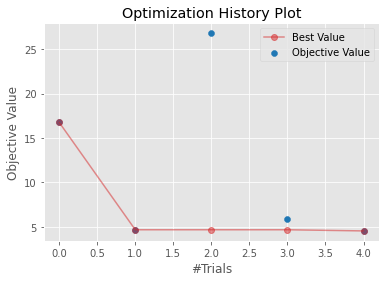

In [13]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [14]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  5
Best trial:
  Value:  4.540961472945751
  Params: 
    train_batch_size: 64
    test_batch_size: 128
    num_epochs: 1600
    learning_rate: 0.023614429514503796
    momentum: 0.6518946756156891
    optimizer: <class 'torch.optim.sgd.SGD'>
    hidden_size: 256
    num_layers: 1
    num_classes: 1


## Plot Results

Epoch: 0, loss: 0.08323287963867188
Epoch: 10, loss: 0.05811202526092529
Epoch: 20, loss: 0.0517028346657753
Epoch: 30, loss: 0.04491131752729416
Epoch: 40, loss: 0.037668753415346146
Epoch: 50, loss: 0.030087798833847046
Epoch: 60, loss: 0.02249097265303135
Epoch: 70, loss: 0.015397404320538044
Epoch: 80, loss: 0.009413724765181541
Epoch: 90, loss: 0.0050162626430392265
Epoch: 100, loss: 0.00232534296810627
Epoch: 110, loss: 0.0010547281708568335
Epoch: 120, loss: 0.0006981181213632226
Epoch: 130, loss: 0.0007846014341339469
Epoch: 140, loss: 0.00101132458075881
Epoch: 150, loss: 0.0012350508477538824
Epoch: 160, loss: 0.0014094088692218065
Epoch: 170, loss: 0.0015313809271901846
Epoch: 180, loss: 0.001611792715266347
Epoch: 190, loss: 0.0016628922894597054
Epoch: 200, loss: 0.001694520702585578
Epoch: 210, loss: 0.0017136307433247566
Epoch: 220, loss: 0.00172484724316746
Epoch: 230, loss: 0.0017311412375420332
Epoch: 240, loss: 0.0017343852669000626
Epoch: 250, loss: 0.00173574849031

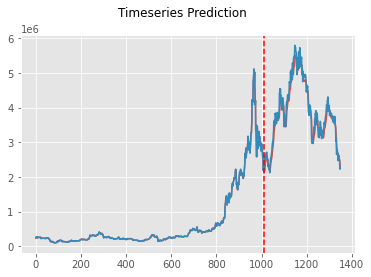

In [15]:
train_dl, test_dl, input_size, x_train, x_test, y_train, y_test = get_data_loader(training_data, 20, study.best_params['train_batch_size'], study.best_params['test_batch_size'])
best_model = LSTM(num_classes=study.best_params['num_classes'], input_size=input_size, hidden_size=study.best_params['hidden_size'], num_layers=study.best_params['num_layers'])
optimizer = study.best_params['optimizer'](best_model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()

train(10, best_model, train_dl, optimizer, criterion, study.best_params['num_epochs'])

pred = test_predict(best_model, test_dl)

predicted_for_plot = scaler.inverse_transform(np.concatenate((y_train, np.expand_dims(pred, axis = 1))))
actual_for_plot = scaler.inverse_transform(np.concatenate((y_train, y_test)))


torch.save(best_model.state_dict(), "lstm.pt")


SMAPE = smape(actual_for_plot, predicted_for_plot)
print(f' \nSMAPE : {SMAPE}')

plt.plot(predicted_for_plot[len(y_test):])
plt.plot(actual_for_plot[len(y_test):])
plt.suptitle('Timeseries Prediction')
plt.axvline(x = y_train.shape[0] - len(y_test), c = 'r', linestyle = '--')
plt.show()

